In [1]:
## Step 0 — Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = stopwords.words('english')

# Optional for better plot aesthetics
sns.set(style="whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1 — Load dataset


In [2]:
# Load CSV
df = pd.read_csv('C:/Users/Dell/Pictures/Predicting-Price-Moves-with-News-Sentiment-week1/Predicting-Price-Moves-with-News-Sentiment-week1/data/raw_analyst_ratings.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
df = df.dropna(subset=['headline', 'date', 'stock'])

# Extract additional columns
df['headline_len_chars'] = df['headline'].str.len()
df['headline_len_words'] = df['headline'].str.split().apply(len)
df['date_only'] = df['date'].dt.date
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.day_name()

# Preview
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_len_chars,headline_len_words,date_only,hour,weekday
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,39,7,2020-06-05,14,Friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,42,7,2020-06-03,14,Wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,29,5,2020-05-26,8,Tuesday
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,44,7,2020-05-22,16,Friday
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,87,14,2020-05-22,15,Friday


## Step 2 — Descriptive Statistics
### 2.1 Headline length

       headline_len_chars  headline_len_words
count        55987.000000        55987.000000
mean            80.015254           12.435726
std             56.126094            8.458581
min             12.000000            2.000000
25%             42.000000            7.000000
50%             63.000000           10.000000
75%             91.000000           14.000000
max            512.000000           77.000000


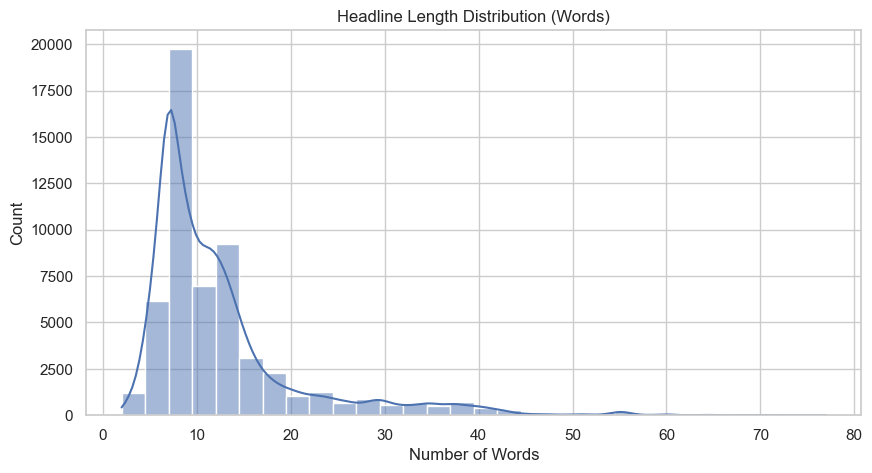

In [3]:
print(df[['headline_len_chars', 'headline_len_words']].describe())

# Histogram of headline length (words)
plt.figure(figsize=(10,5))
sns.histplot(df['headline_len_words'], bins=30, kde=True)
plt.title('Headline Length Distribution (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

### 2.2 Number of articles per publisher

publisher
Benzinga Newsdesk          14750
Lisa Levin                 12408
ETF Professor               4362
Paul Quintaro               4212
Benzinga Newsdesk           3177
Benzinga Insights           2332
Vick Meyer                  2128
Charles Gross               1790
Hal Lindon                  1470
Benzinga_Newsdesk           1239
Eddie Staley                1003
vishwanath@benzinga.com      924
Shanthi Rexaline             887
Monica Gerson                611
Wayne Duggan                 465
Nelson Hem                   345
Jayson Derrick               337
Craig Jones                  310
luke@benzinga.com            271
Javier Hasse                 250
Name: count, dtype: int64


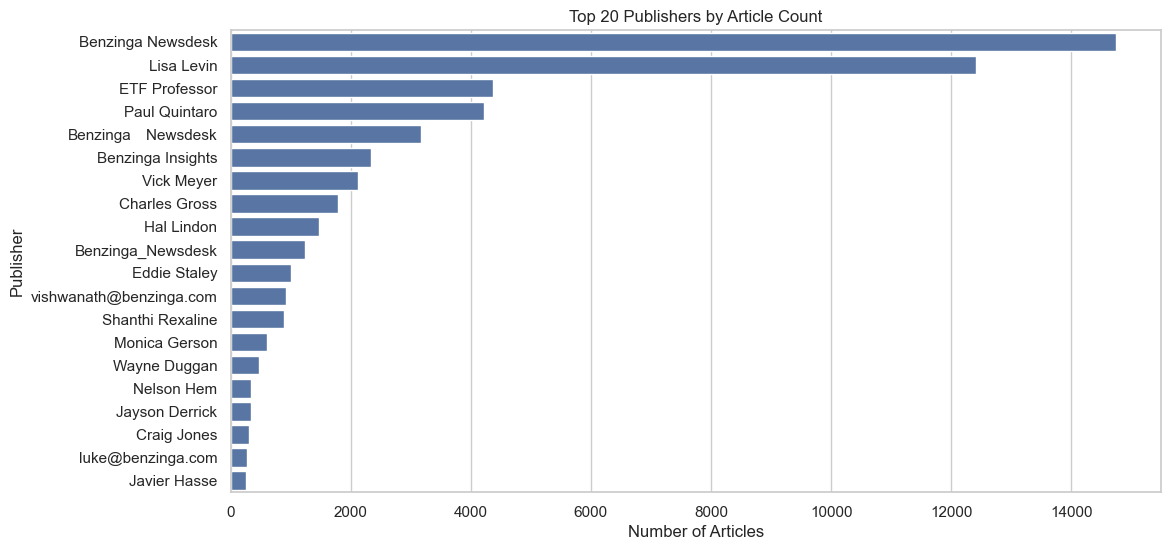

In [4]:
publisher_counts = df['publisher'].value_counts().head(20)
print(publisher_counts)

plt.figure(figsize=(12,6))
sns.barplot(x=publisher_counts.values, y=publisher_counts.index)
plt.title('Top 20 Publishers by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Publisher')
plt.show()

### 2.3 Number of articles per stock

stock
ZX      10
A       10
AA      10
AAC     10
ZUMZ    10
AAL     10
AAMC    10
AAME    10
AAN     10
AAOI    10
AAON    10
ZIOP    10
ZION    10
ZINC    10
ZGNX    10
ZFGN    10
ZFC     10
ZEUS    10
ZEN     10
ZBRA    10
Name: count, dtype: int64


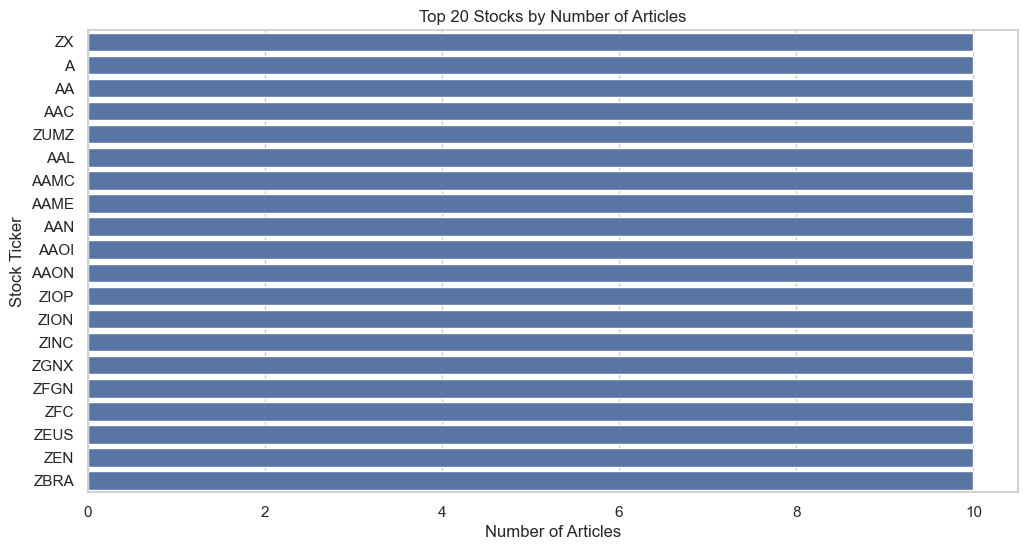

In [5]:
stock_counts = df['stock'].value_counts().head(20)
print(stock_counts)

plt.figure(figsize=(12,6))
sns.barplot(x=stock_counts.values, y=stock_counts.index)
plt.title('Top 20 Stocks by Number of Articles')
plt.xlabel('Number of Articles')
plt.ylabel('Stock Ticker')
plt.show()

## Step 3 — Time Series Analysis

### 3.1 Daily publication frequency

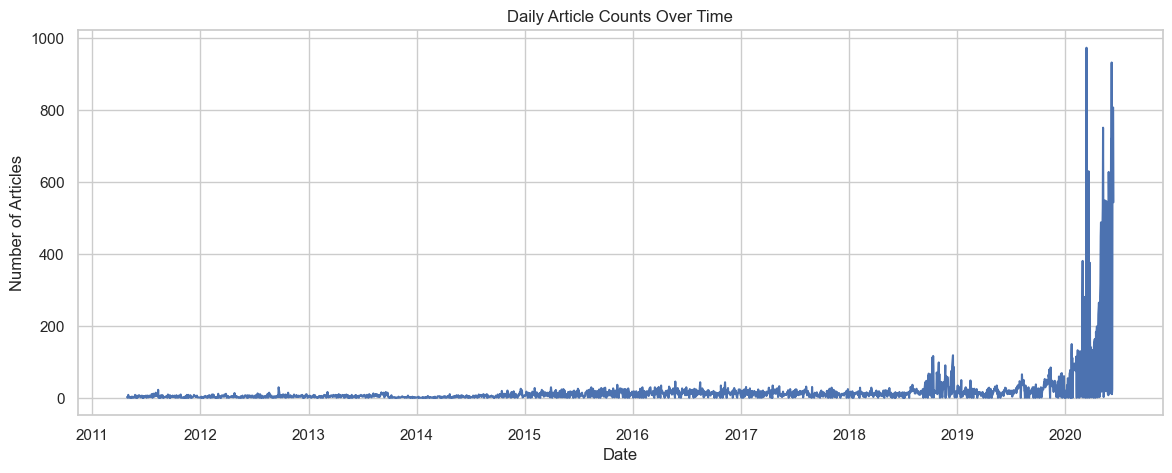

In [6]:
daily_counts = df.groupby('date_only').size()

plt.figure(figsize=(14,5))
daily_counts.plot()
plt.title('Daily Article Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()


### 3.2 Hour-of-day and weekday distributions

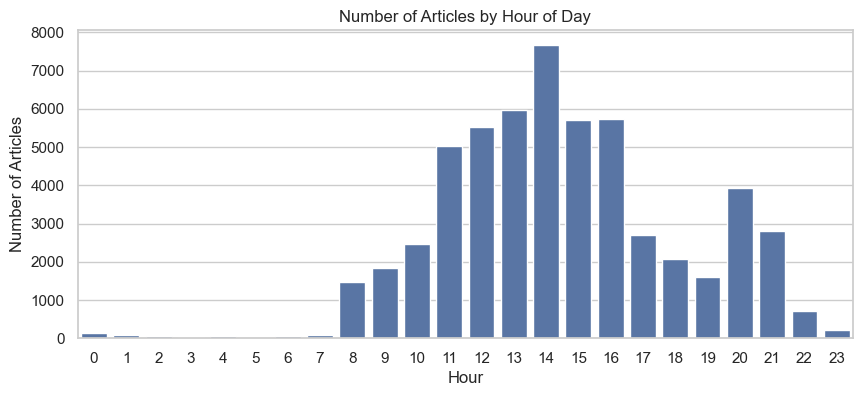

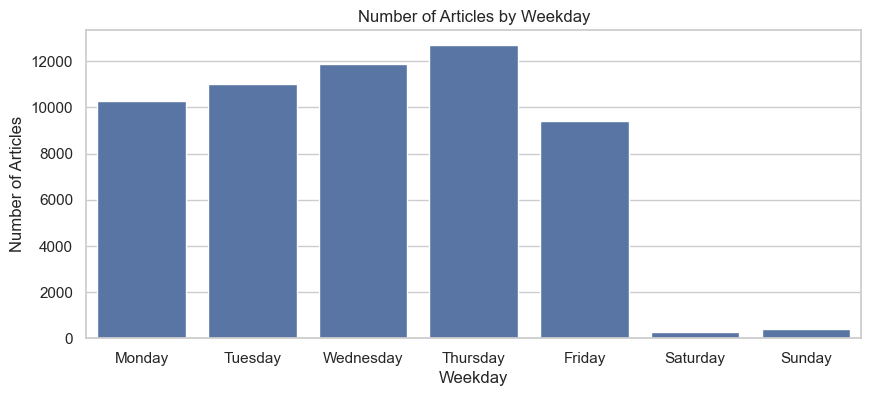

In [7]:
plt.figure(figsize=(10,4))
sns.countplot(x='hour', data=df)
plt.title('Number of Articles by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Articles')
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(x='weekday', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Number of Articles by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Articles')
plt.show()


## Step 4 — Text Analysis (Keyword Extraction / Topic Modeling)

### 4.1 TF-IDF top keywords

In [8]:
tfidf = TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1,2), stop_words=stop_words)
X = tfidf.fit_transform(df['headline'])
top_n = 20
indices = X.sum(axis=0).A1.argsort()[-top_n:][::-1]
terms = [tfidf.get_feature_names_out()[i] for i in indices]
print("Top 20 Keywords/Phrases:", terms)


Top 20 Keywords/Phrases: ['stocks', 'week', '52', '52 week', 'hit', 'stocks hit', 'hit 52', 'lows', 'week lows', 'thursday', 'highs', 'week highs', 'friday', 'shares', 'market', 'lows thursday', 'yesterday', 'price', 'biggest', 'target']


### 4.2  LDA topic modeling

In [9]:
# Using gensim (optional)
from gensim import corpora, models
import gensim

# Tokenize
texts = df['headline'].str.lower().str.split().tolist()
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)
topics = lda_model.print_topics(num_words=5)
for t in topics:
    print(t)


(0, '0.042*"the" + 0.042*"of" + 0.032*"trading" + 0.031*"are" + 0.030*"shares"')
(1, '0.054*"in" + 0.036*"stocks" + 0.028*"session" + 0.026*"moving" + 0.023*"market"')
(2, '0.050*"stocks" + 0.049*"that" + 0.049*"52-week" + 0.048*"on" + 0.045*"hit"')
(3, '0.076*"to" + 0.052*"on" + 0.049*"price" + 0.044*"target" + 0.031*"maintains"')
(4, '0.045*"for" + 0.033*"to" + 0.028*"of" + 0.016*"etfs" + 0.012*"with"')


## Step 5 — Publisher Analysis

### 5.1 Publisher domains

publisher_domain
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
benzinga.com          1196
Eddie Staley          1003
Shanthi Rexaline       887
Monica Gerson          611
Wayne Duggan           465
Nelson Hem             345
Jayson Derrick         337
Craig Jones            310
Javier Hasse           250
Luke J Jacobi          166
Name: count, dtype: int64


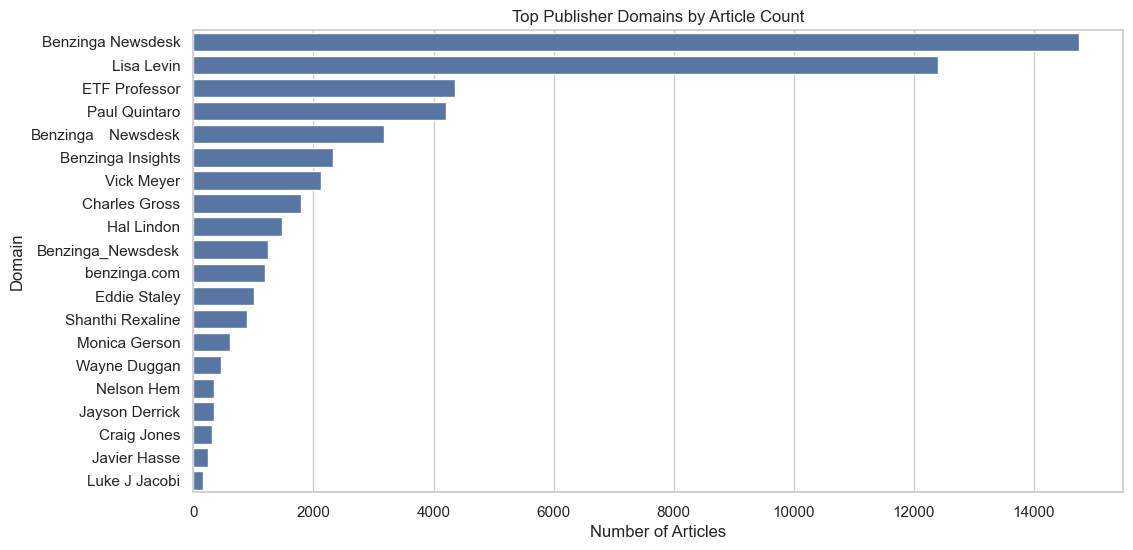

In [10]:
from urllib.parse import urlparse

def extract_domain(s):
    if '@' in s:
        return s.split('@')[-1]
    return s
df['publisher_domain'] = df['publisher'].apply(extract_domain)

domain_counts = df['publisher_domain'].value_counts().head(20)
print(domain_counts)

plt.figure(figsize=(12,6))
sns.barplot(x=domain_counts.values, y=domain_counts.index)
plt.title('Top Publisher Domains by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Domain')
plt.show()


## Step 0 — Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = stopwords.words('english')

# Optional for better plot aesthetics
sns.set(style="whitegrid")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1 — Load dataset

In [ ]:
# Load CSV
df = pd.read_csv('C:/Users/Dell/Pictures/Predicting-Price-Moves-with-News-Sentiment-week1/Predicting-Price-Moves-with-News-Sentiment-week1/data/raw_analyst_ratings.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
df = df.dropna(subset=['headline', 'date', 'stock'])

# Extract additional columns
df['headline_len_chars'] = df['headline'].str.len()
df['headline_len_words'] = df['headline'].str.split().apply(len)
df['date_only'] = df['date'].dt.date
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.day_name()

# Preview
df.head()


,Unnamed: 0,headline,url,publisher,date,stock,headline_len_chars,headline_len_words,date_only,hour,weekday
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,39,7,2020-06-05,14,Friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,42,7,2020-06-03,14,Wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,29,5,2020-05-26,8,Tuesday
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,44,7,2020-05-22,16,Friday
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,87,14,2020-05-22,15,Friday


## Step 2 — Descriptive Statistics

### 2.1 Headline length

       headline_len_chars  headline_len_words
count        55987.000000        55987.000000
mean            80.015254           12.435726
std             56.126094            8.458581
min             12.000000            2.000000
25%             42.000000            7.000000
50%             63.000000           10.000000
75%             91.000000           14.000000
max            512.000000           77.000000


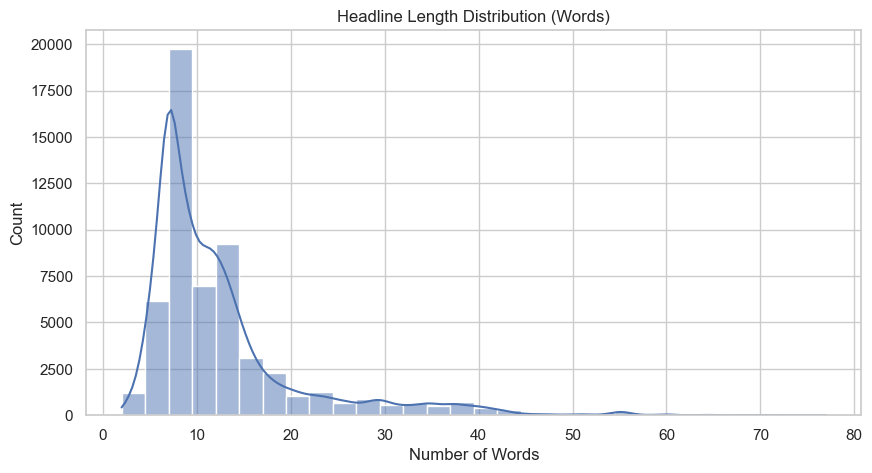

In [ ]:
print(df[['headline_len_chars', 'headline_len_words']].describe())

# Histogram of headline length (words)
plt.figure(figsize=(10,5))
sns.histplot(df['headline_len_words'], bins=30, kde=True)
plt.title('Headline Length Distribution (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()


### 2.2 Number of articles per publisher

publisher
Benzinga Newsdesk          14750
Lisa Levin                 12408
ETF Professor               4362
Paul Quintaro               4212
Benzinga Newsdesk           3177
Benzinga Insights           2332
Vick Meyer                  2128
Charles Gross               1790
Hal Lindon                  1470
Benzinga_Newsdesk           1239
Eddie Staley                1003
vishwanath@benzinga.com      924
Shanthi Rexaline             887
Monica Gerson                611
Wayne Duggan                 465
Nelson Hem                   345
Jayson Derrick               337
Craig Jones                  310
luke@benzinga.com            271
Javier Hasse                 250
Name: count, dtype: int64


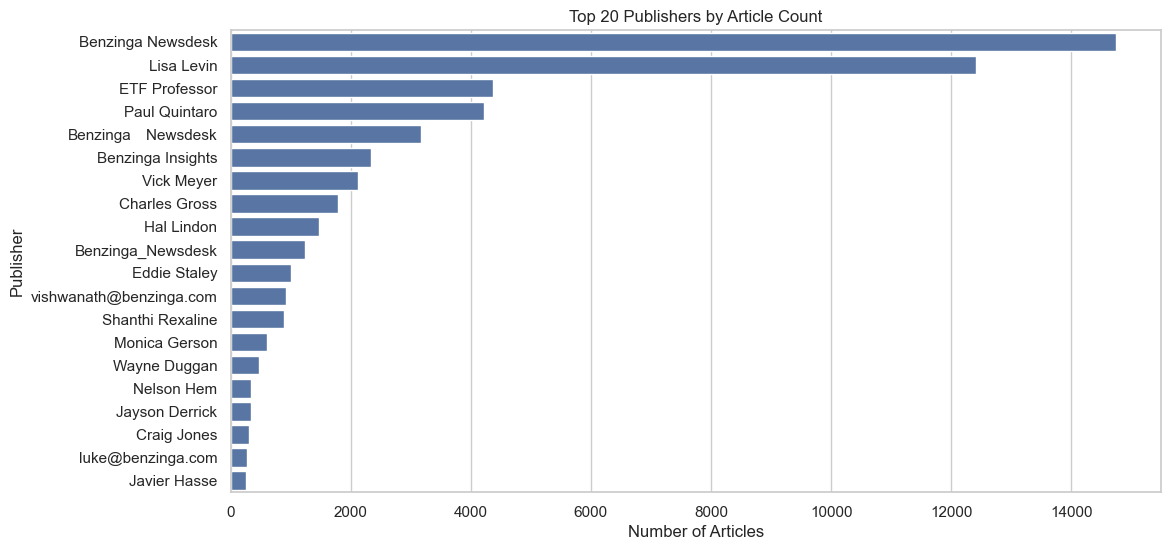

In [ ]:
publisher_counts = df['publisher'].value_counts().head(20)
print(publisher_counts)

plt.figure(figsize=(12,6))
sns.barplot(x=publisher_counts.values, y=publisher_counts.index)
plt.title('Top 20 Publishers by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Publisher')
plt.show()


### 2.3 Number of articles per stock

stock
ZX      10
A       10
AA      10
AAC     10
ZUMZ    10
AAL     10
AAMC    10
AAME    10
AAN     10
AAOI    10
AAON    10
ZIOP    10
ZION    10
ZINC    10
ZGNX    10
ZFGN    10
ZFC     10
ZEUS    10
ZEN     10
ZBRA    10
Name: count, dtype: int64


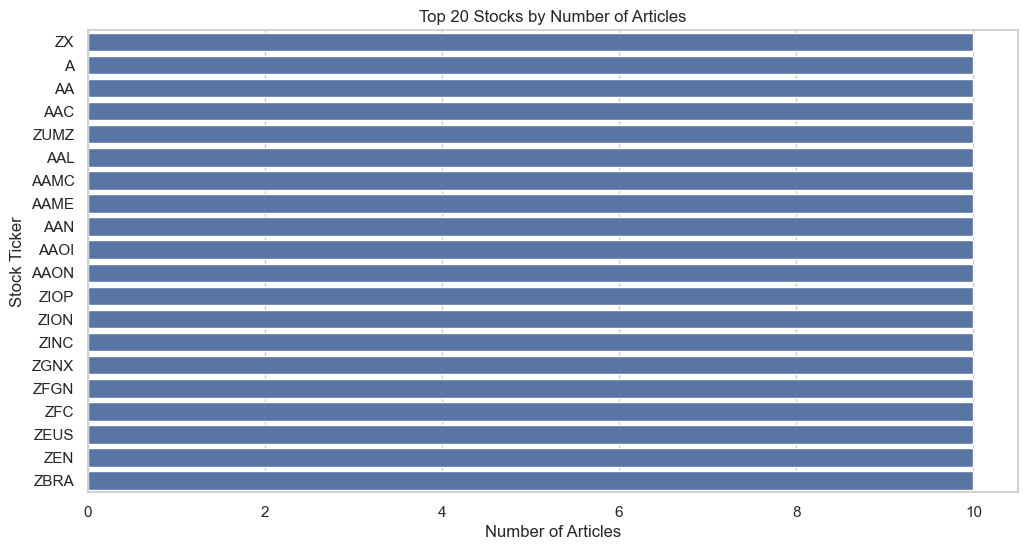

In [ ]:
stock_counts = df['stock'].value_counts().head(20)
print(stock_counts)

plt.figure(figsize=(12,6))
sns.barplot(x=stock_counts.values, y=stock_counts.index)
plt.title('Top 20 Stocks by Number of Articles')
plt.xlabel('Number of Articles')
plt.ylabel('Stock Ticker')
plt.show()
